In [14]:
%reload_ext autoreload
%autoreload 2
#%matplotlib inline

# Analysis of the Dynamic Solow Model

### Imports 

In [29]:
import pickle
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from kaleido.scopes.plotly import PlotlyScope
import chart_studio.plotly as py
import plotly.graph_objs as go
scope = PlotlyScope()



In [4]:
from solowModel import SolowModel
from phase_diagram import PhaseDiagram

ModuleNotFoundError: No module named 'numdifftools'

In [48]:
def heatmap(df, xlabel, ylabel, xvars, yvars, save=''):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(8,6)
    temp = ax.imshow(df.values, origin='lower')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.label_outer()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 4))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(-4, -3))
    plt.xticks(range(df.shape[0]), df.columns, fontsize=12, rotation=45)
    plt.yticks(range(df.shape[1]), df.index, fontsize=12)
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(ax.get_yticks()[::5])
    ax.set_xticklabels(["{:.1e}".format(xvars[i]) for i in ax.get_xticks()])
    ax.set_yticklabels(["{:.1e}".format(yvars[i]) for i in ax.get_yticks()])
    fig.colorbar(temp)
    plt.tight_layout()
    if save != '':
        plt.savefig(save, bbox_inches='tight')
    plt.show()

## Approximation of the Asymptotic Constants

#### Solver Functions

In [3]:
def name_extractor(filename):
    temp = filename.split('_')
    g = 'g_'+str(int(temp[2][1:]))
    c2 = 'c2_'+str(float(temp[7]))
    e = 'e_'+str(float(temp[3][1:]))
    return '_'.join([g,c2,e])

In [4]:
def extract_g_c2(filename, string=False):
    parts = filename.split('_')
    # locate g
    for i,part in enumerate(parts):
        if part[0] == 'g':
            gamma = int(part[1:])
        if part == 'c2':
            c2 = float(parts[i+1])
    if string:
        "g_{}_c2_{:.1e}".format(gamma,c2)
    else:
        return (gamma, c2)

In [5]:
sims = {}

for path in os.listdir('new'):
    if ".df" in path:
        file = open('new/'+path, 'rb')
        sims[extract_g_c2(path)] = pickle.load(file)
        file.close()

In [6]:
gamma_list = list(set([g[0] for g in sims.keys()]))
c2_list = list(set([g[1] for g in sims.keys()]))
#print(gamma_list, c2_list)

In [130]:
df_g = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
for g in gamma_list:
    for c2 in c2_list:
        df_g.loc[c2,g]=sims[(g,c2)].g.mean()
df_g.index = [float(i) for i in df_g.index]
df_g = df_g.astype(float)

In [87]:
x,y=[],[]
for i in df_g.index:
    q=df_g.loc[i,:].astype(float).abs().argmin()
    print(q)

30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30


In [38]:
colorscale = [[0, '#edf8fb'], [.3, '#b3cde3'],  [.6, '#8856a7'],  [1, '#810f7c']]
heatmap = go.Heatmap(z=df_g.values, x=df_g.columns, y=df_g.index, colorscale=colorscale)
#scatter = go.Scatter(x=,y=)
py.iplot([heatmap], filename='solow_g-heatmap')

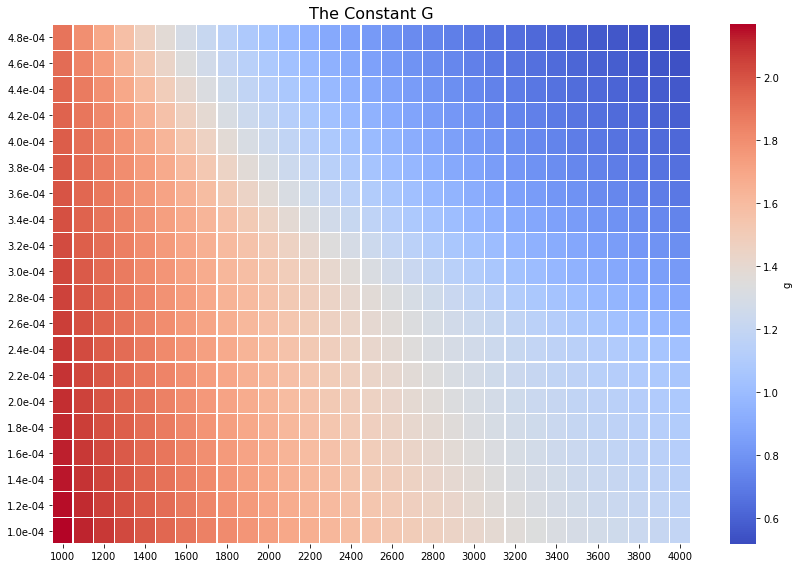

In [85]:
y_l = ['{:.1e}'.format(float(i)) for i in df_div.index]
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)
sns.heatmap(df_g.astype(float), cmap='coolwarm', cbar_kws={'label': 'g'}, yticklabels=y_l, xticklabels=2, linewidths=.1)
ax.set_title('The Constant G', fontsize=16)
ax.tick_params(axis='x', labelrotation= 0)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

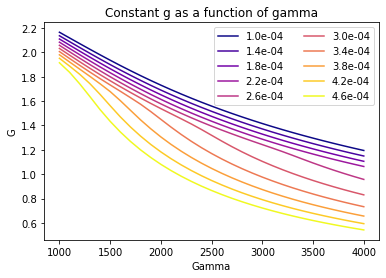

In [126]:
# Mapping the divergence linearly
from matplotlib.pyplot import cm
colors = cm.plasma(np.linspace(0,1,int(df_g.shape[0]/2)))
fig, ax = plt.subplots(1,1)
for i,c in zip(range(0,int(df.shape[0]),2),colors):
    ax.plot(df_g.iloc[i,:], label='{:.1e}'.format(float(df_g.index[i])), color=c)

ax.set_title('Constant g as a function of gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('G')
ax.legend(ncol=2)
plt.show()


In [102]:
df_g.shape[1]

31

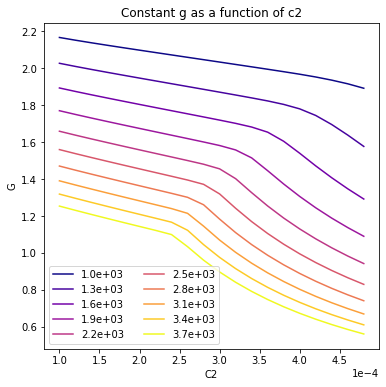

In [143]:
# Mapping the divergence linearly
from matplotlib.pyplot import cm
n = int(df_g.shape[1]/3)
colors = cm.plasma(np.linspace(0,1,n))
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
for i,c in zip(range(0,df_g.shape[1],3),colors):
    ax.plot(df_g.iloc[:,i], label='{:.1e}'.format(float(df_g.columns[i])), color=c)

ax.set_title('Constant g as a function of c2')
ax.set_xlabel('C2')
ax.set_ylabel('G')
#ax.set_xticklabels([float(i) for i in df_g.index])
ax.ticklabel_format(axis='x', style='sci', scilimits=(5,-1))
ax.legend(ncol=2)
plt.show()


In [39]:
scatters = []
for i in df_g.index[::4]:
    scatters.append(go.Scatter(x=df_g.columns, y=df_g.loc[i,:], name='c2={:.1e}'.format(i)))
py.iplot(scatters, filename='solow_g_vs_gamma')

In [40]:
scatters = []
for i in df_g.columns[::4]:
    scatters.append(go.Scatter(x=df_g.index, y=df_g.loc[:,i], name='gamma={:.1e}'.format(i)))
py.iplot(scatters, filename='solow_g_vs_c2')

In [49]:
df_div = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
for g in gamma_list:
    for c2 in c2_list:
        df = sims[(g,c2)]
        df_div.loc[c2,g]=(df.psi_ks - df.psi_kd).mean()
df_div.index.name='c2'
df_div.columns.name='Gamma'

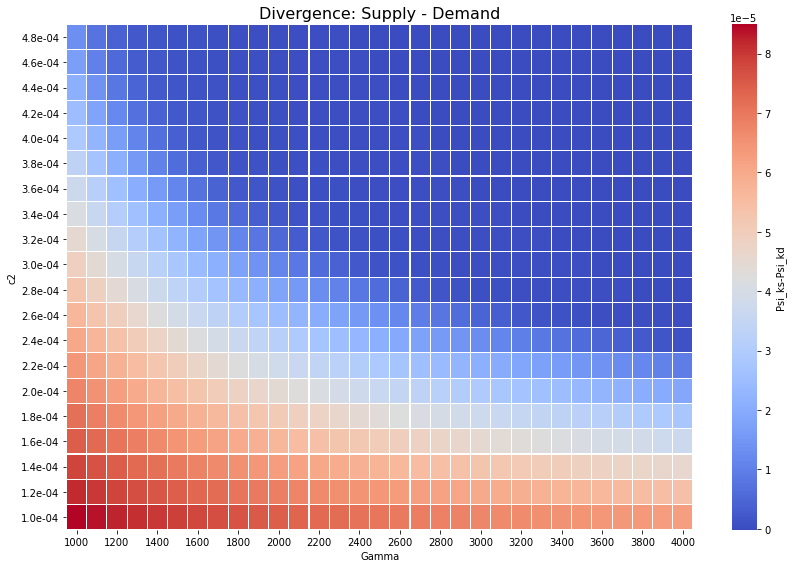

In [84]:
import seaborn as sns
y_l = ['{:.1e}'.format(float(i)) for i in df_div.index]
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)
sns.heatmap(df_div.astype(float), cmap='coolwarm', cbar_kws={'label': 'Psi_ks-Psi_kd'}, yticklabels=y_l, xticklabels=2, linewidths=.1)
ax.set_title('Divergence: Supply - Demand', fontsize=16)
ax.tick_params(axis='x', labelrotation= 0)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [64]:
ax.get_yticklabels()[0]

Text(0, 0.5, '0.0001')

In [46]:
heatmap = go.Heatmap(z=df_div.values, x=df_div.columns, y=df_div.index, colorscale=colorscale, 
                     labels=dict(x="Gamma", y="C2", color="g"))
layout = go.Layout(title="Divergence Psi_ks - Psi_kd")
py.iplot([heatmap], layout=layout, filename='solow_ks_min_kd')

ValueError: Invalid property specified for object of type plotly.graph_objs.Heatmap: 'labels'

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default  palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.heatmap.ColorBar` instance
            or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use`zmin` and `zmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Greys,YlGnBu,Greens,YlOrR
            d,Bluered,RdBu,Reds,Blues,Picnic,Rainbow,Portland,Jet,H
            ot,Blackbody,Earth,Electric,Viridis,Cividis.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data are filled in. It is defaulted
            to true if `z` is a one dimensional array and `zsmooth`
            is not false; otherwise it is defaulted to false.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.heatmap.Hoverlabel`
            instance or dict with compatible properties
        hoverongaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data have hover labels associated
            with them.
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. Dates are formatted
            using d3-time-format's syntax %{variable|d3-time-
            format}, for example "Day: %{2019-01-01|%A}".
            https://github.com/d3/d3-time-format#locale_format for
            details on the date formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        reversescale
            Reverses the color mapping if true. If true, `zmin`
            will correspond to the last color in the array and
            `zmax` will correspond to the first color.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        stream
            :class:`plotly.graph_objects.heatmap.Stream` instance
            or dict with compatible properties
        text
            Sets the text elements associated with each z value.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        transpose
            Transposes the z data.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xgap
            Sets the horizontal gap (in pixels) between bricks.
        xsrc
            Sets the source reference on Chart Studio Cloud for  x
            .
        xtype
            If "array", the heatmap's x coordinates are given by
            "x" (the default behavior when `x` is provided). If
            "scaled", the heatmap's x coordinates are given by "x0"
            and "dx" (the default behavior when `x` is not
            provided).
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ygap
            Sets the vertical gap (in pixels) between bricks.
        ysrc
            Sets the source reference on Chart Studio Cloud for  y
            .
        ytype
            If "array", the heatmap's y coordinates are given by
            "y" (the default behavior when `y` is provided) If
            "scaled", the heatmap's y coordinates are given by "y0"
            and "dy" (the default behavior when `y` is not
            provided)
        z
            Sets the z data.
        zauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `z`) or the
            bounds set in `zmin` and `zmax`  Defaults to `false`
            when `zmin` and `zmax` are set by the user.
        zhoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. See: https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format
        zmax
            Sets the upper bound of the color domain. Value should
            have the same units as in `z` and if set, `zmin` must
            be set as well.
        zmid
            Sets the mid-point of the color domain by scaling
            `zmin` and/or `zmax` to be equidistant to this point.
            Value should have the same units as in `z`. Has no
            effect when `zauto` is `false`.
        zmin
            Sets the lower bound of the color domain. Value should
            have the same units as in `z` and if set, `zmax` must
            be set as well.
        zsmooth
            Picks a smoothing algorithm use to smooth `z` data.
        zsrc
            Sets the source reference on Chart Studio Cloud for  z
            .
        

In [145]:
df_yks = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
for g in gamma_list:
    for c2 in c2_list:
        df = sims[(g,c2)]
        df_yks.loc[c2,g]=(df.psi_ks - df.psi_y).mean()

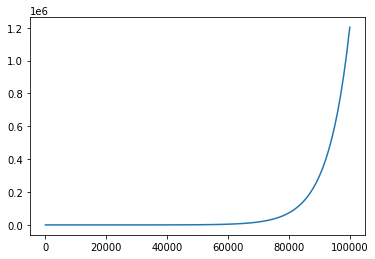

In [159]:
plt.figure()
x = np.linspace(1,1e5,101)
plt.plot(x, np.exp(1.4e-4*x))
plt.show()

In [161]:
(26-9)/1e6

1.7e-05

In [157]:
1.4e-4*1e6


140.0

In [155]:
1e6/250


4000.0

In [153]:
for g in gamma_list:
    for c2 in c2_list:
        df = sims[(g,c2)]
        print('{:.3e}, {:.3e}'.format(df.psi_ks.mean(), df.psi_y.mean()))

1.410e-04, 1.407e-04
1.489e-04, 1.494e-04
1.287e-04, 1.283e-04
1.489e-04, 1.494e-04
1.174e-04, 1.169e-04
1.489e-04, 1.494e-04
1.487e-04, 1.487e-04
1.489e-04, 1.494e-04
1.368e-04, 1.365e-04
1.489e-04, 1.494e-04
1.249e-04, 1.244e-04
1.489e-04, 1.494e-04
1.489e-04, 1.494e-04
1.452e-04, 1.449e-04
1.489e-04, 1.494e-04
1.327e-04, 1.323e-04
1.489e-04, 1.494e-04
1.211e-04, 1.206e-04
1.489e-04, 1.494e-04
1.489e-04, 1.494e-04
1.292e-04, 1.287e-04
1.489e-04, 1.492e-04
1.206e-04, 1.201e-04
1.488e-04, 1.490e-04
1.126e-04, 1.121e-04
1.447e-04, 1.444e-04
1.352e-04, 1.348e-04
1.489e-04, 1.493e-04
1.262e-04, 1.258e-04
1.489e-04, 1.492e-04
1.179e-04, 1.173e-04
1.485e-04, 1.486e-04
1.415e-04, 1.412e-04
1.322e-04, 1.318e-04
1.489e-04, 1.493e-04
1.234e-04, 1.229e-04
1.489e-04, 1.491e-04
1.152e-04, 1.147e-04
1.473e-04, 1.471e-04
1.383e-04, 1.380e-04
1.375e-04, 1.371e-04
1.489e-04, 1.494e-04
1.263e-04, 1.259e-04
1.489e-04, 1.494e-04
1.160e-04, 1.155e-04
1.489e-04, 1.493e-04
1.453e-04, 1.451e-04
1.489e-04, 1.

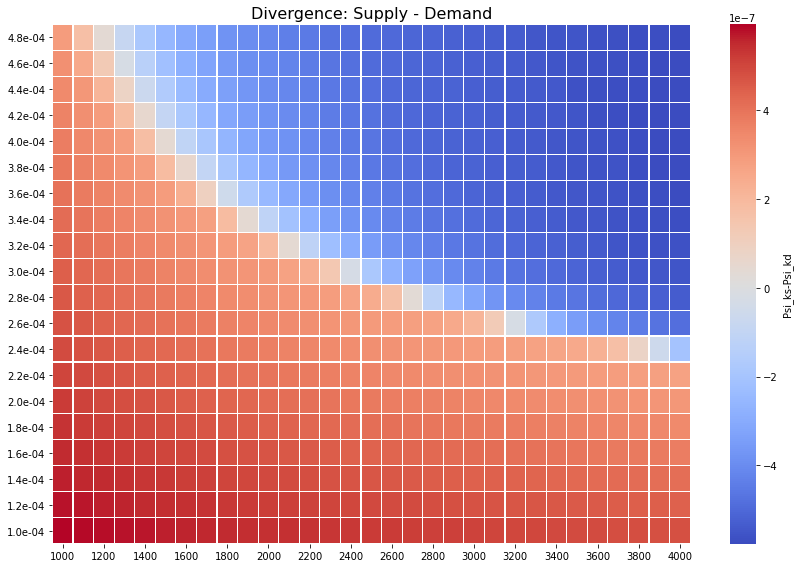

In [146]:
import seaborn as sns
y_l = ['{:.1e}'.format(float(i)) for i in df_yks.index]
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)
sns.heatmap(df_yks.astype(float), cmap='coolwarm', cbar_kws={'label': 'Psi_ks-Psi_kd'}, yticklabels=y_l, xticklabels=2, linewidths=.1)
ax.set_title('Divergence: Supply - Demand', fontsize=16)
ax.tick_params(axis='x', labelrotation= 0)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [84]:
heatmap = go.Heatmap(z=df_yks.values, x=df_yks.columns, y=df_yks.index, colorscale=colorscale)
py.iplot([heatmap], filename='solow_g-yks')